In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase

In [23]:
include("./Data_Input.jl")
using .DataImport

include("./Distributions.jl")
using .MakeDistributions

include("./Plots.jl")
using .Plots

In [4]:
sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e3);

 `sep_data` contains two hosts: `M3` and `F4`.\
 For each host there are four possible environments: `FECES`, `ORALCAVITY`, `L_PALM`, `R_PALM`.\
 Then each environment consists of a dataset stored in a dataFrame with the following features:\
 **project_id**: identifies projects\
**sample_id**: identifies samples (communities) gathered within the same environment\
**run_id**: identifies the machine run to identify species in a sample. Multiple runs are possible within the same sample\
**otu_id**: identifies species\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run\
**experiment_day**: day passed from the beginning of data collection

In [5]:
first(sep_data["M3"]["ORALCAVITY"], 5)

5×7 DataFrame
 Row │ project_id  otu_id  count    sample_id   run_id      experiment_day  nr ⋯
     │ String      Int32   Float64  String      String      Int32           Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ERP021896     3616      1.0  ERS1579465  ERR1868309               0   8 ⋯
   2 │ ERP021896     5336    112.0  ERS1579465  ERR1868309               0   8
   3 │ ERP021896    10473      9.0  ERS1579465  ERR1868309               0   8
   4 │ ERP021896    10764      2.0  ERS1579465  ERR1868309               0   8
   5 │ ERP021896    21026      1.0  ERS1579465  ERR1868309               0   8 ⋯
                                                                1 column omitted

# Distributions

In [24]:
AFDs = []
TAYLORs = []
MADs = []
AutoCorrs = []
PSDs = []
CrossCorrs = []

cutoffs = Dict("M3" => Dict("FECES" => -15.1, "ORALCAVITY" => -15.2, "L_PALM" => -14.4, "R_PALM" => -15.5),
              "F4" => Dict("FECES" => -13.8, "ORALCAVITY" => -12.8, "L_PALM" => -13.6, "R_PALM" => -12.3)
             )

for (key, sub_data) in sep_data
    for (subkey, data) in sub_data

        data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

        otus = unique(data.otu_id)
        max_day = maximum(data.experiment_day) + 1 # add 1 because experiment_day starts from 0
        otu_groups = groupby(data, :otu_id)

        if length(otus) < 1e1
            println("Skipping $(key[1]) $subkey")
            continue
        end
        println("$(key[1]) $subkey")

        y = zeros(max_day, length(otus))
        env_data = []
        otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

        for g in otu_groups
            otu = g.otu_id[1]
            i = otu_index[otu]
            for (t, fval) in zip(g.experiment_day, g.f)
                if 1 <= t+1 <= max_day
                    y[t+1, i] = fval
                end
            end

            y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
            push!(env_data, y[:,i])
        end

        matrix_data = hcat(env_data...)
        
        afd = MakeDistributions.make_AFD(matrix_data; missing_thresh=Int(floor(size(data,1) / 50)), c=exp(cutoffs[key][subkey]), Δb=0.5, env="$(key[1]) $subkey")
        push!(AFDs, afd)
    
        taylor = MakeDistributions.make_Taylor(matrix_data; c=exp(cutoffs[key][subkey]), Δb=0.5, env="$(key[1]) $subkey")
        push!(TAYLORs, taylor)
    
        mad = MakeDistributions.make_MAD(matrix_data; c=exp(cutoffs[key][subkey]), Δb=0.5, env="$(key[1]) $subkey")
        push!(MADs, mad)

        miss = Int(floor(size(matrix_data, 1) / 3))
        max_lag = Int(floor(size(matrix_data, 1) / 10))
        autocorr = MakeDistributions.make_lagCorr(matrix_data; env="$(key[1]) $subkey", missing_thresh = miss, max_lag = max_lag)
        push!(AutoCorrs, autocorr)

        psd = MakeDistributions.make_PSD(matrix_data; env="$(key[1]) $subkey", missing_thresh = miss, freq_range=(-1.5, -0.5))
        push!(PSDs, psd)

        crosscorr = MakeDistributions.make_lagCrossCorr(matrix_data; env="$(key[1]) $subkey", lags=[10, 2, 0], missing_thresh = miss)
        push!(CrossCorrs, crosscorr)
    end
end

M ORALCAVITY
M L_PALM
M FECES
M R_PALM
F ORALCAVITY
F L_PALM
F FECES
F R_PALM


### AFD

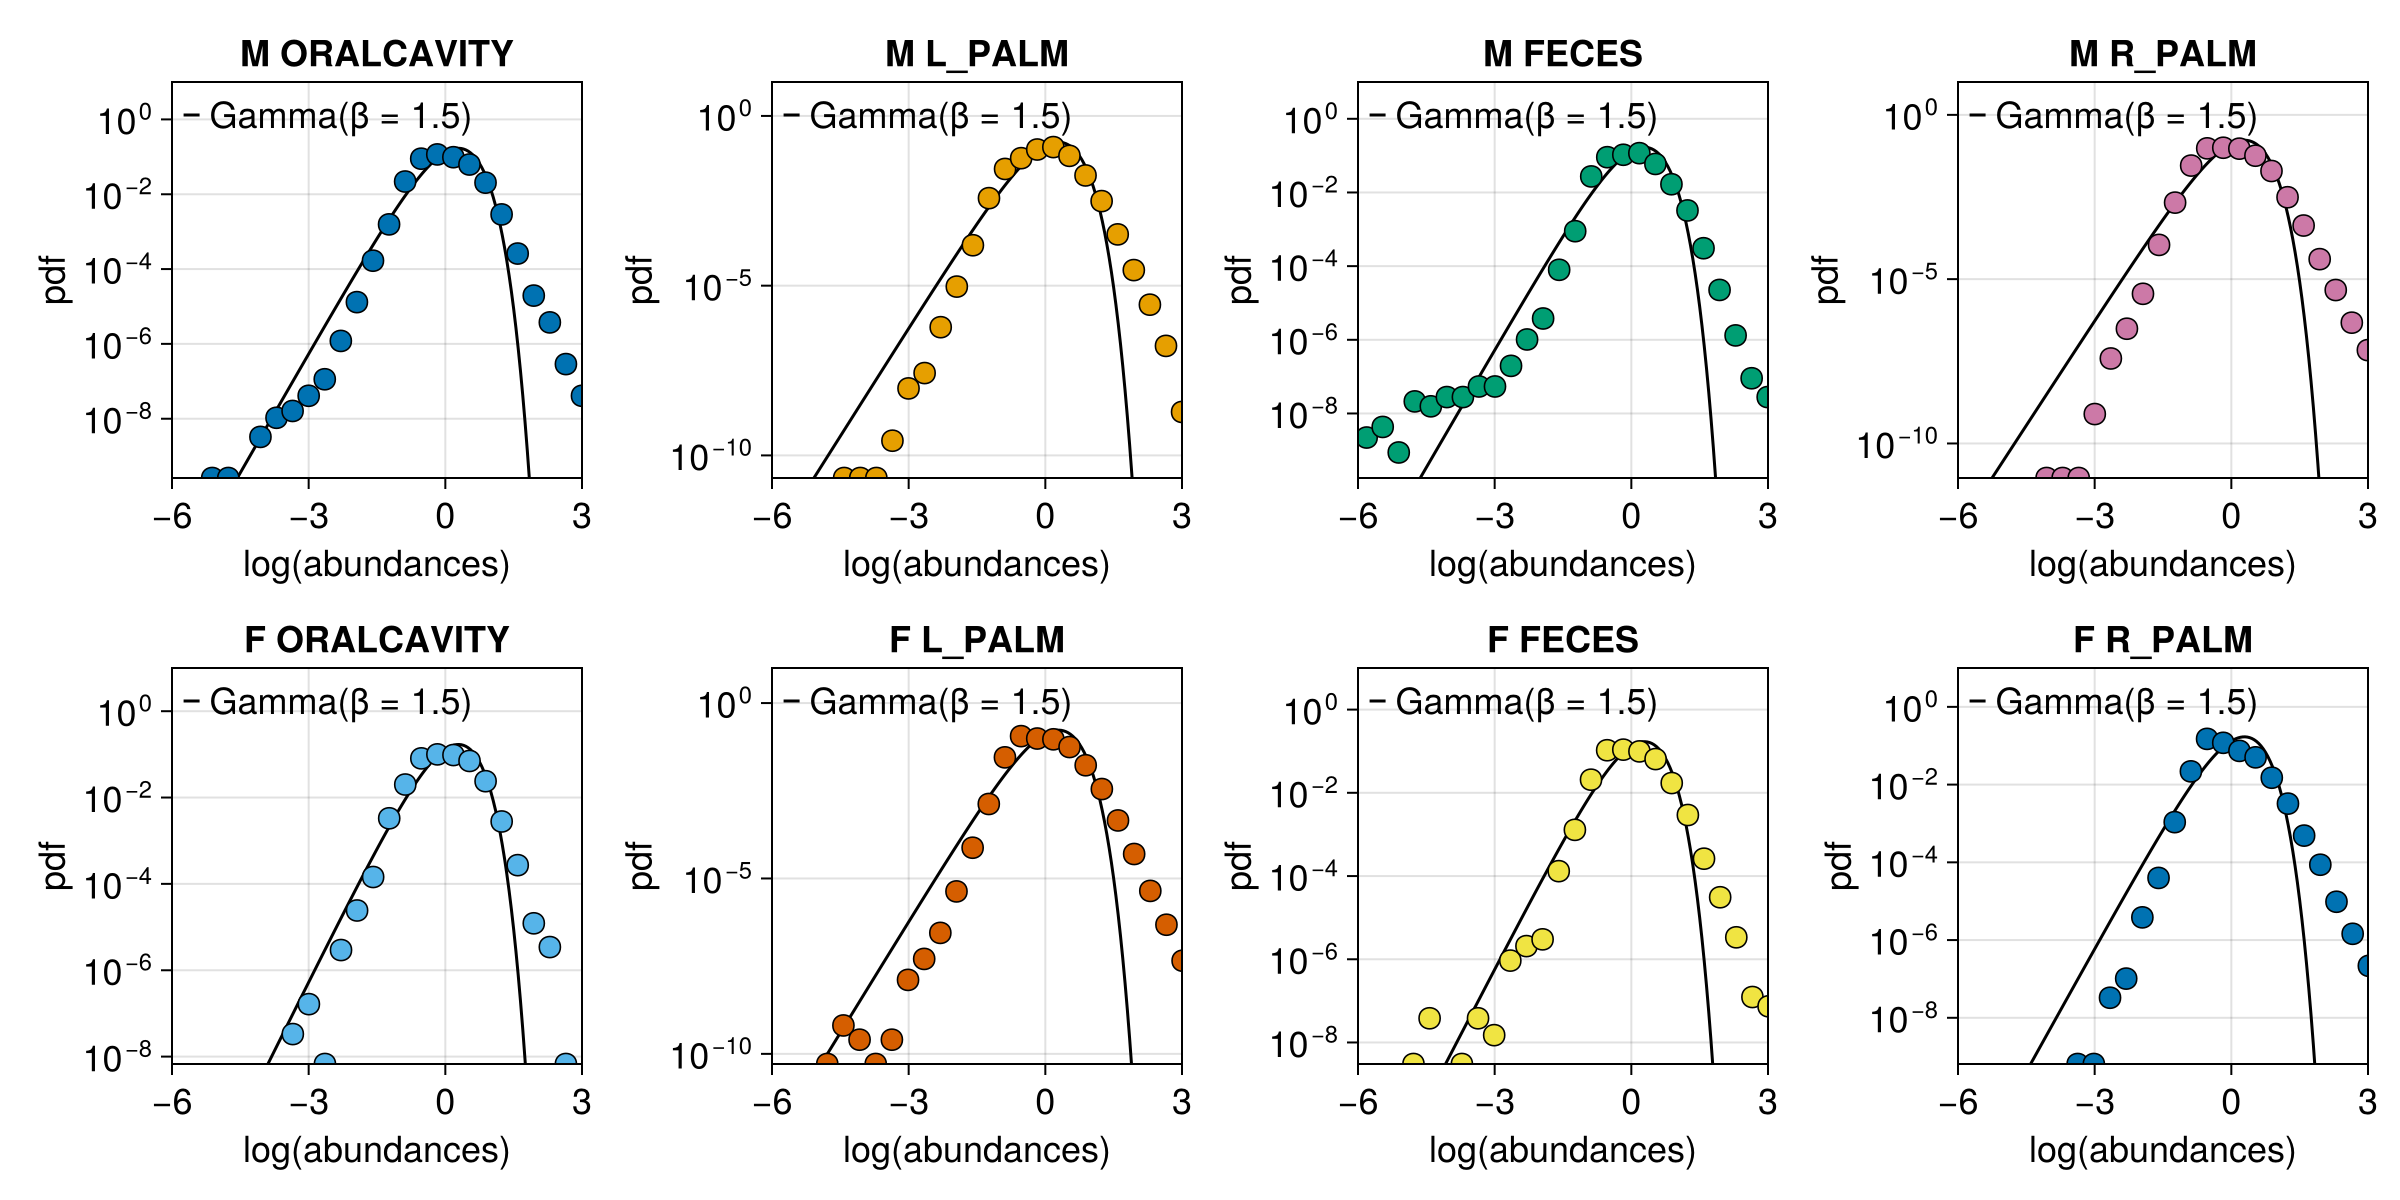

CairoMakie.Screen{IMAGE}


In [25]:
fig = Plots.combine_AFD_histograms(AFDs, nrows=2, ncols=4, savepath=nothing)
display(fig)

### Taylor

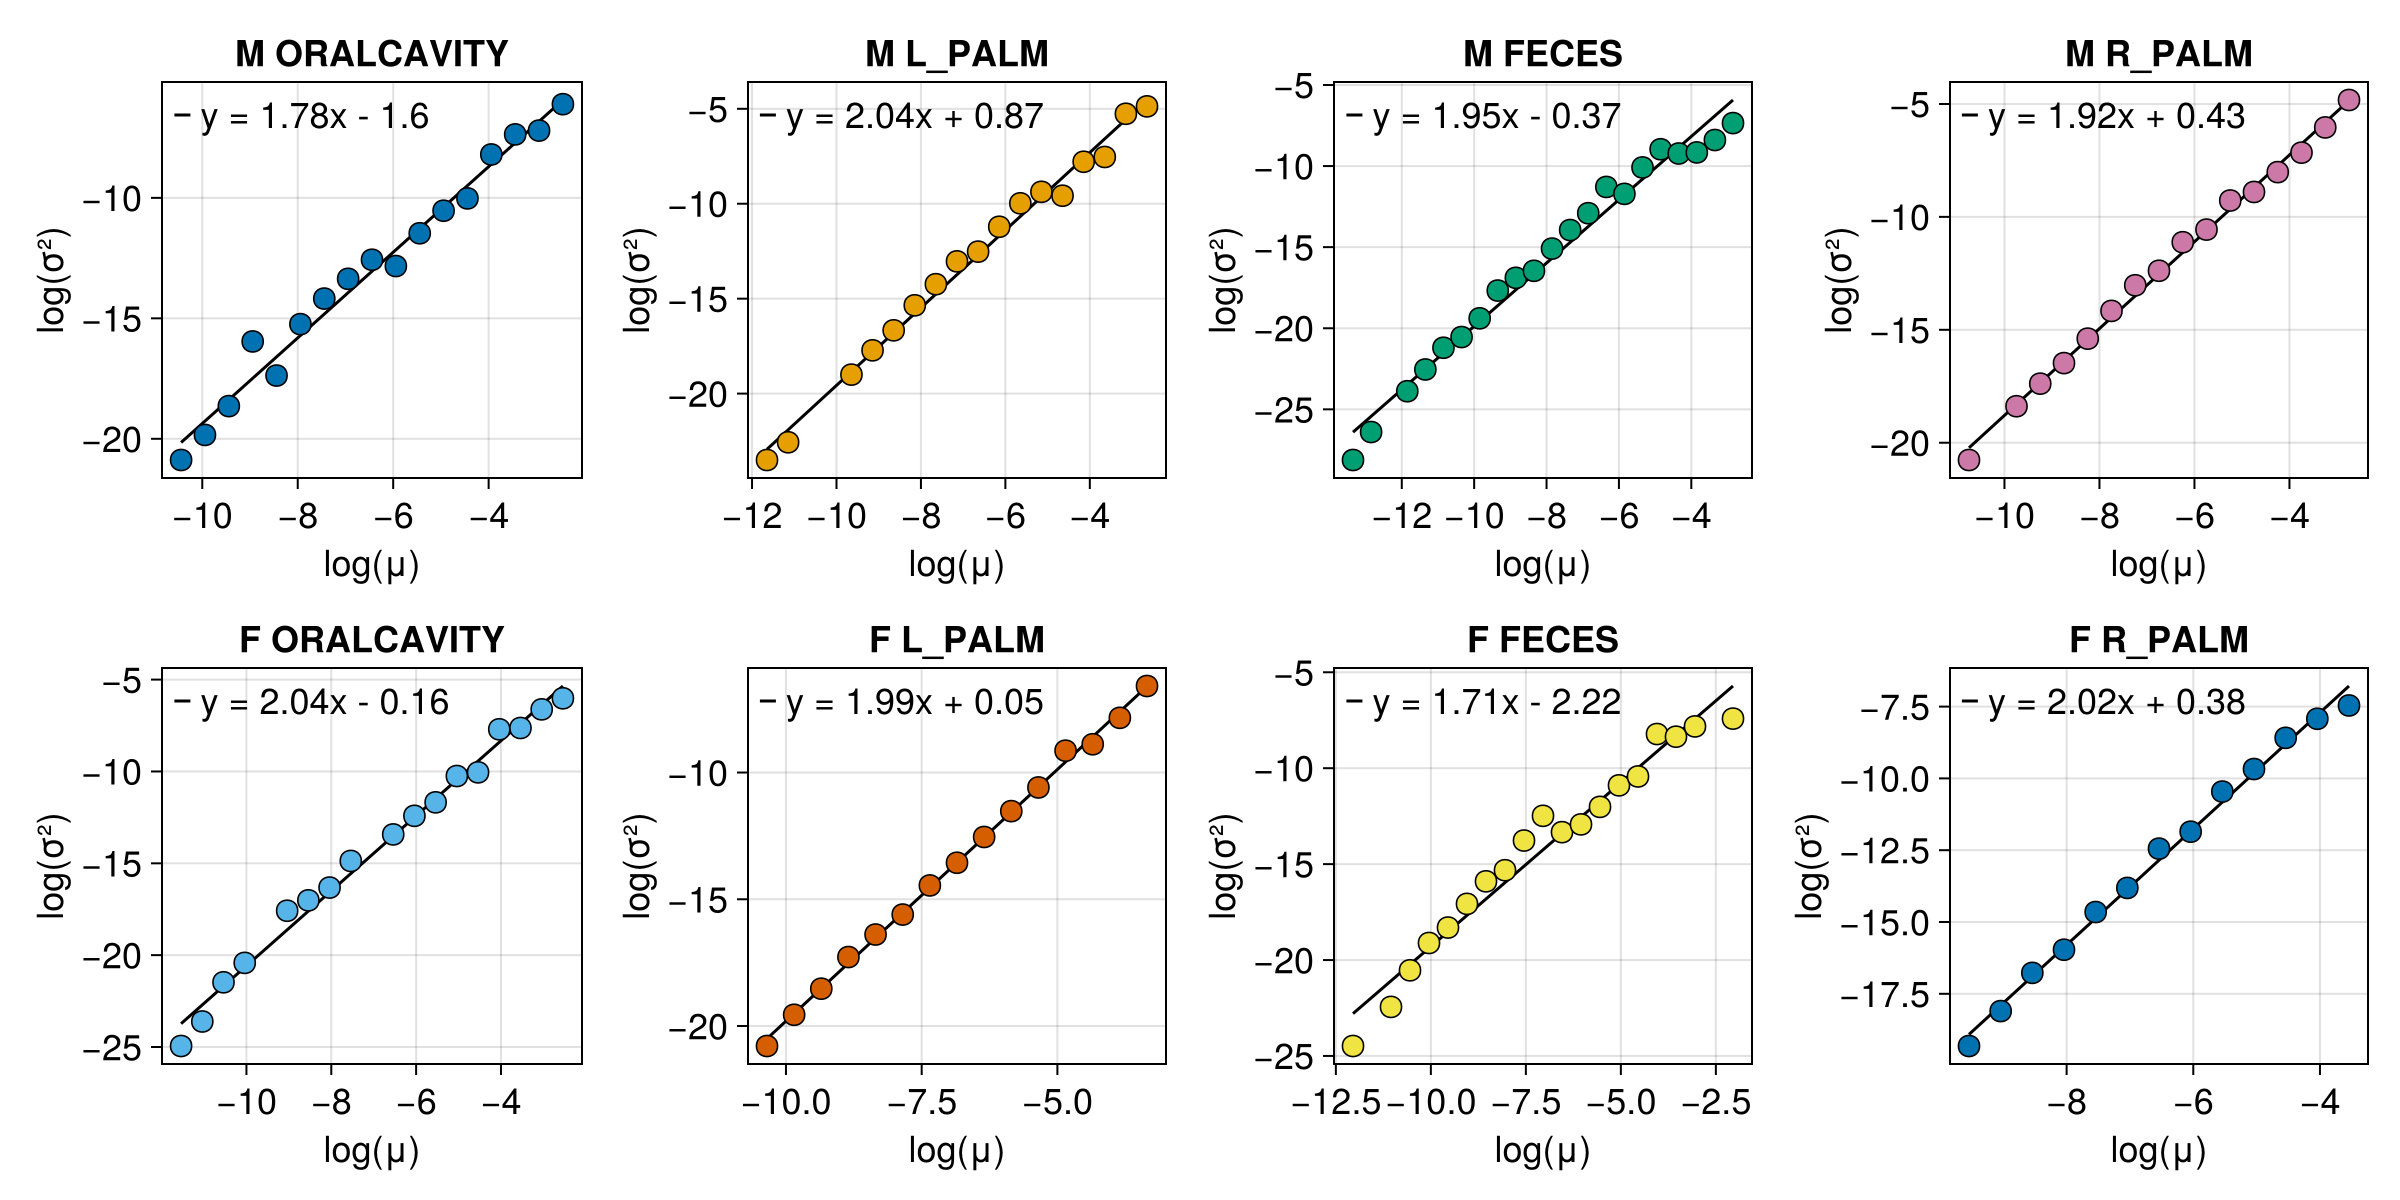

CairoMakie.Screen{IMAGE}


In [12]:
fig = Plots.combine_Taylor_histograms(TAYLORs, nrows=2, ncols=4, savepath=nothing)
display(fig)

### MAD

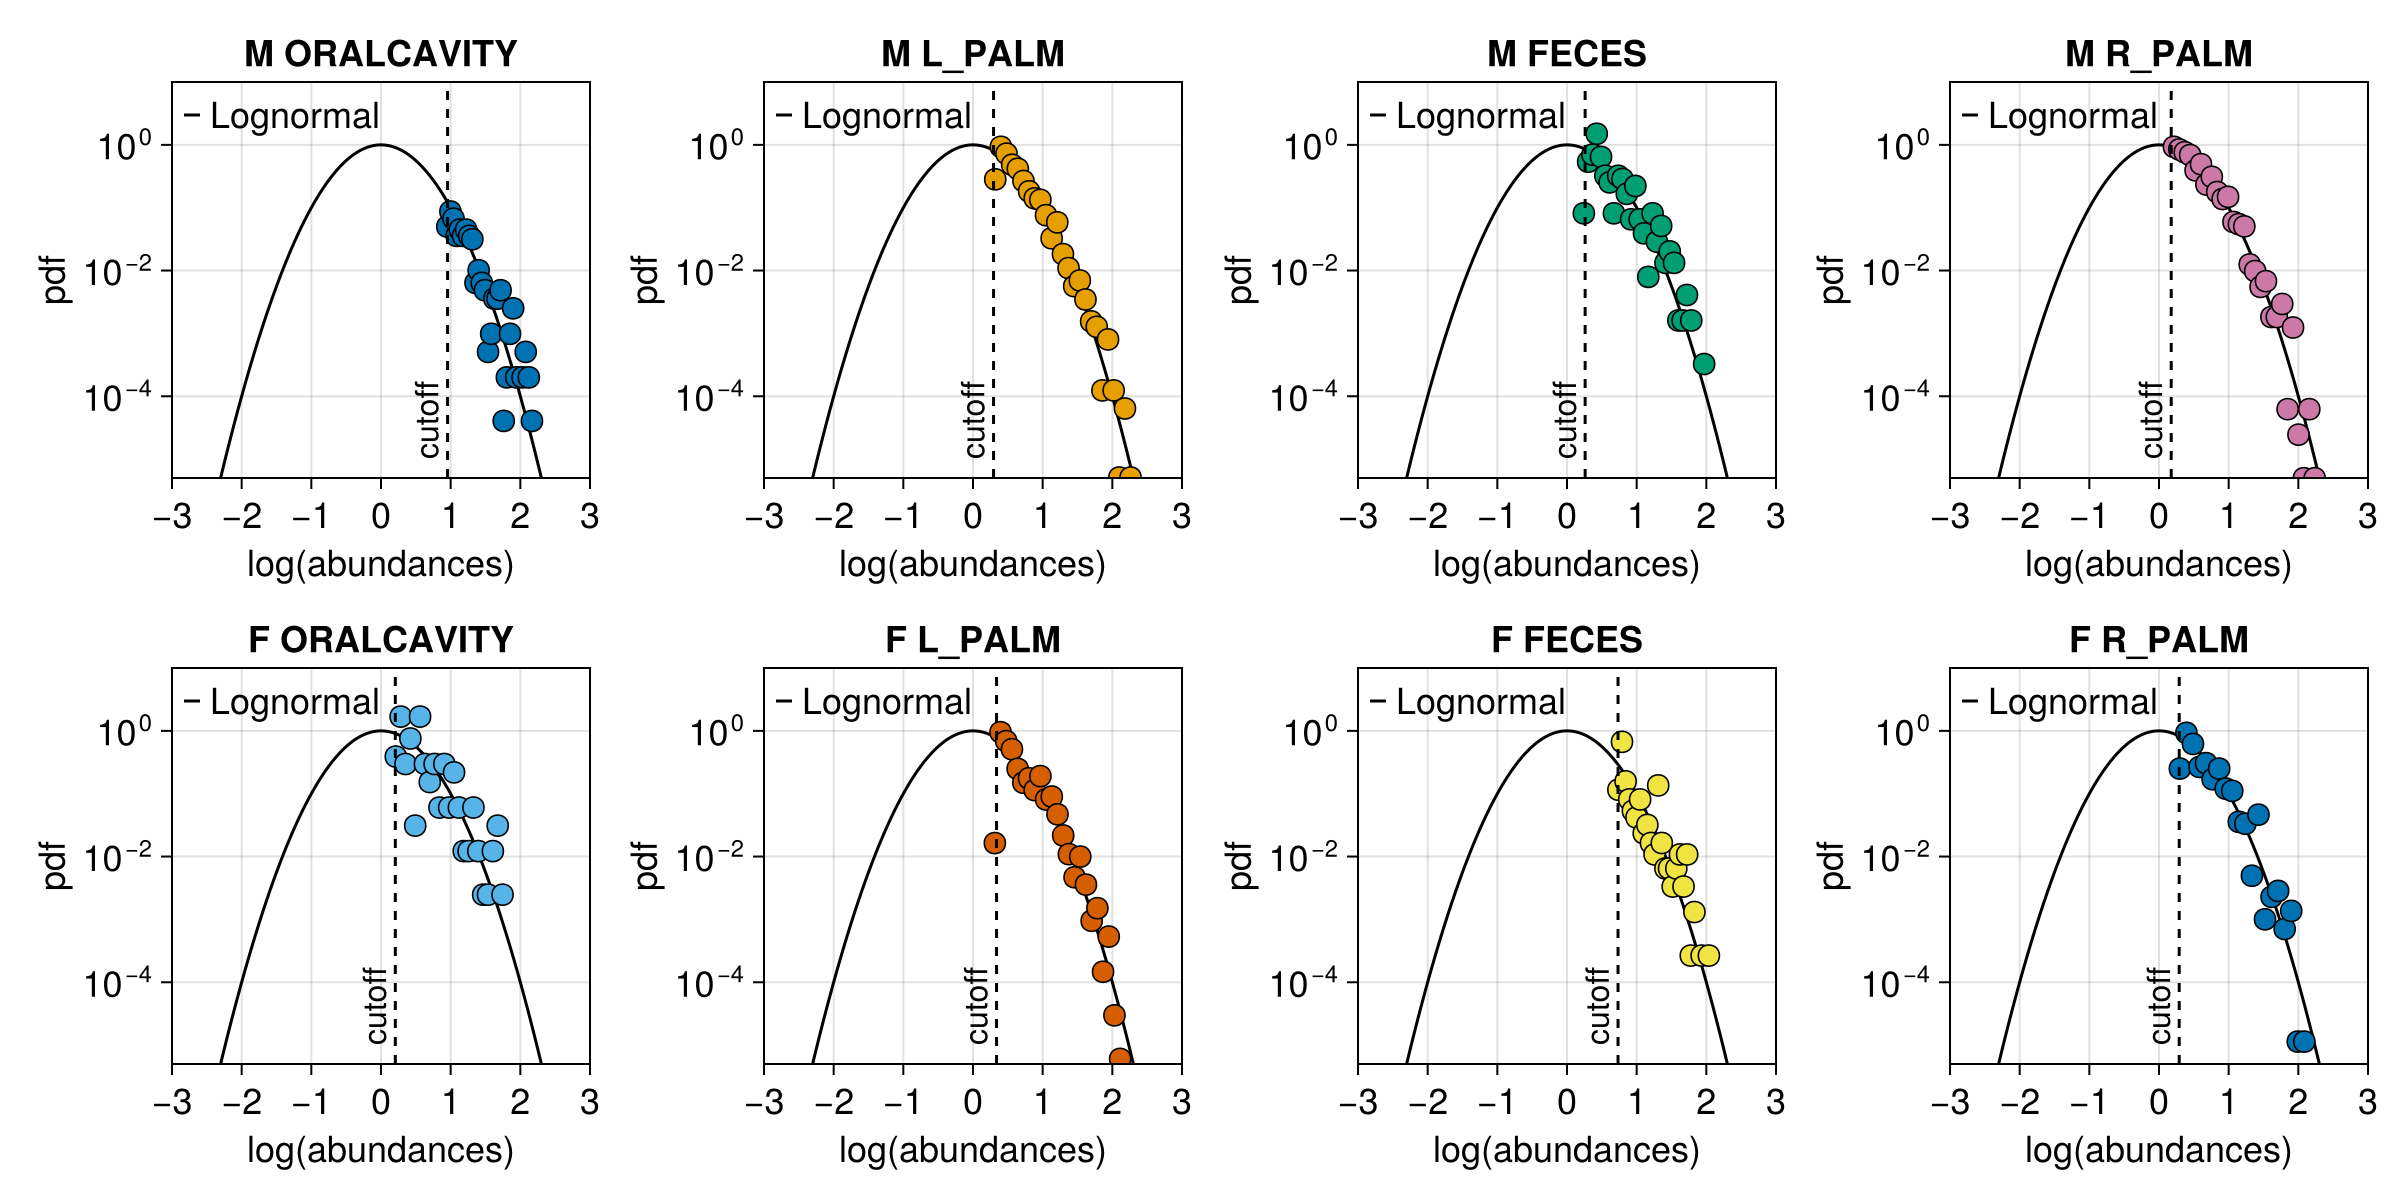

CairoMakie.Screen{IMAGE}


In [13]:
fig = Plots.combine_MAD_histograms(MADs, nrows=2, ncols=4, savepath=nothing)
display(fig)

### Auto Correlations

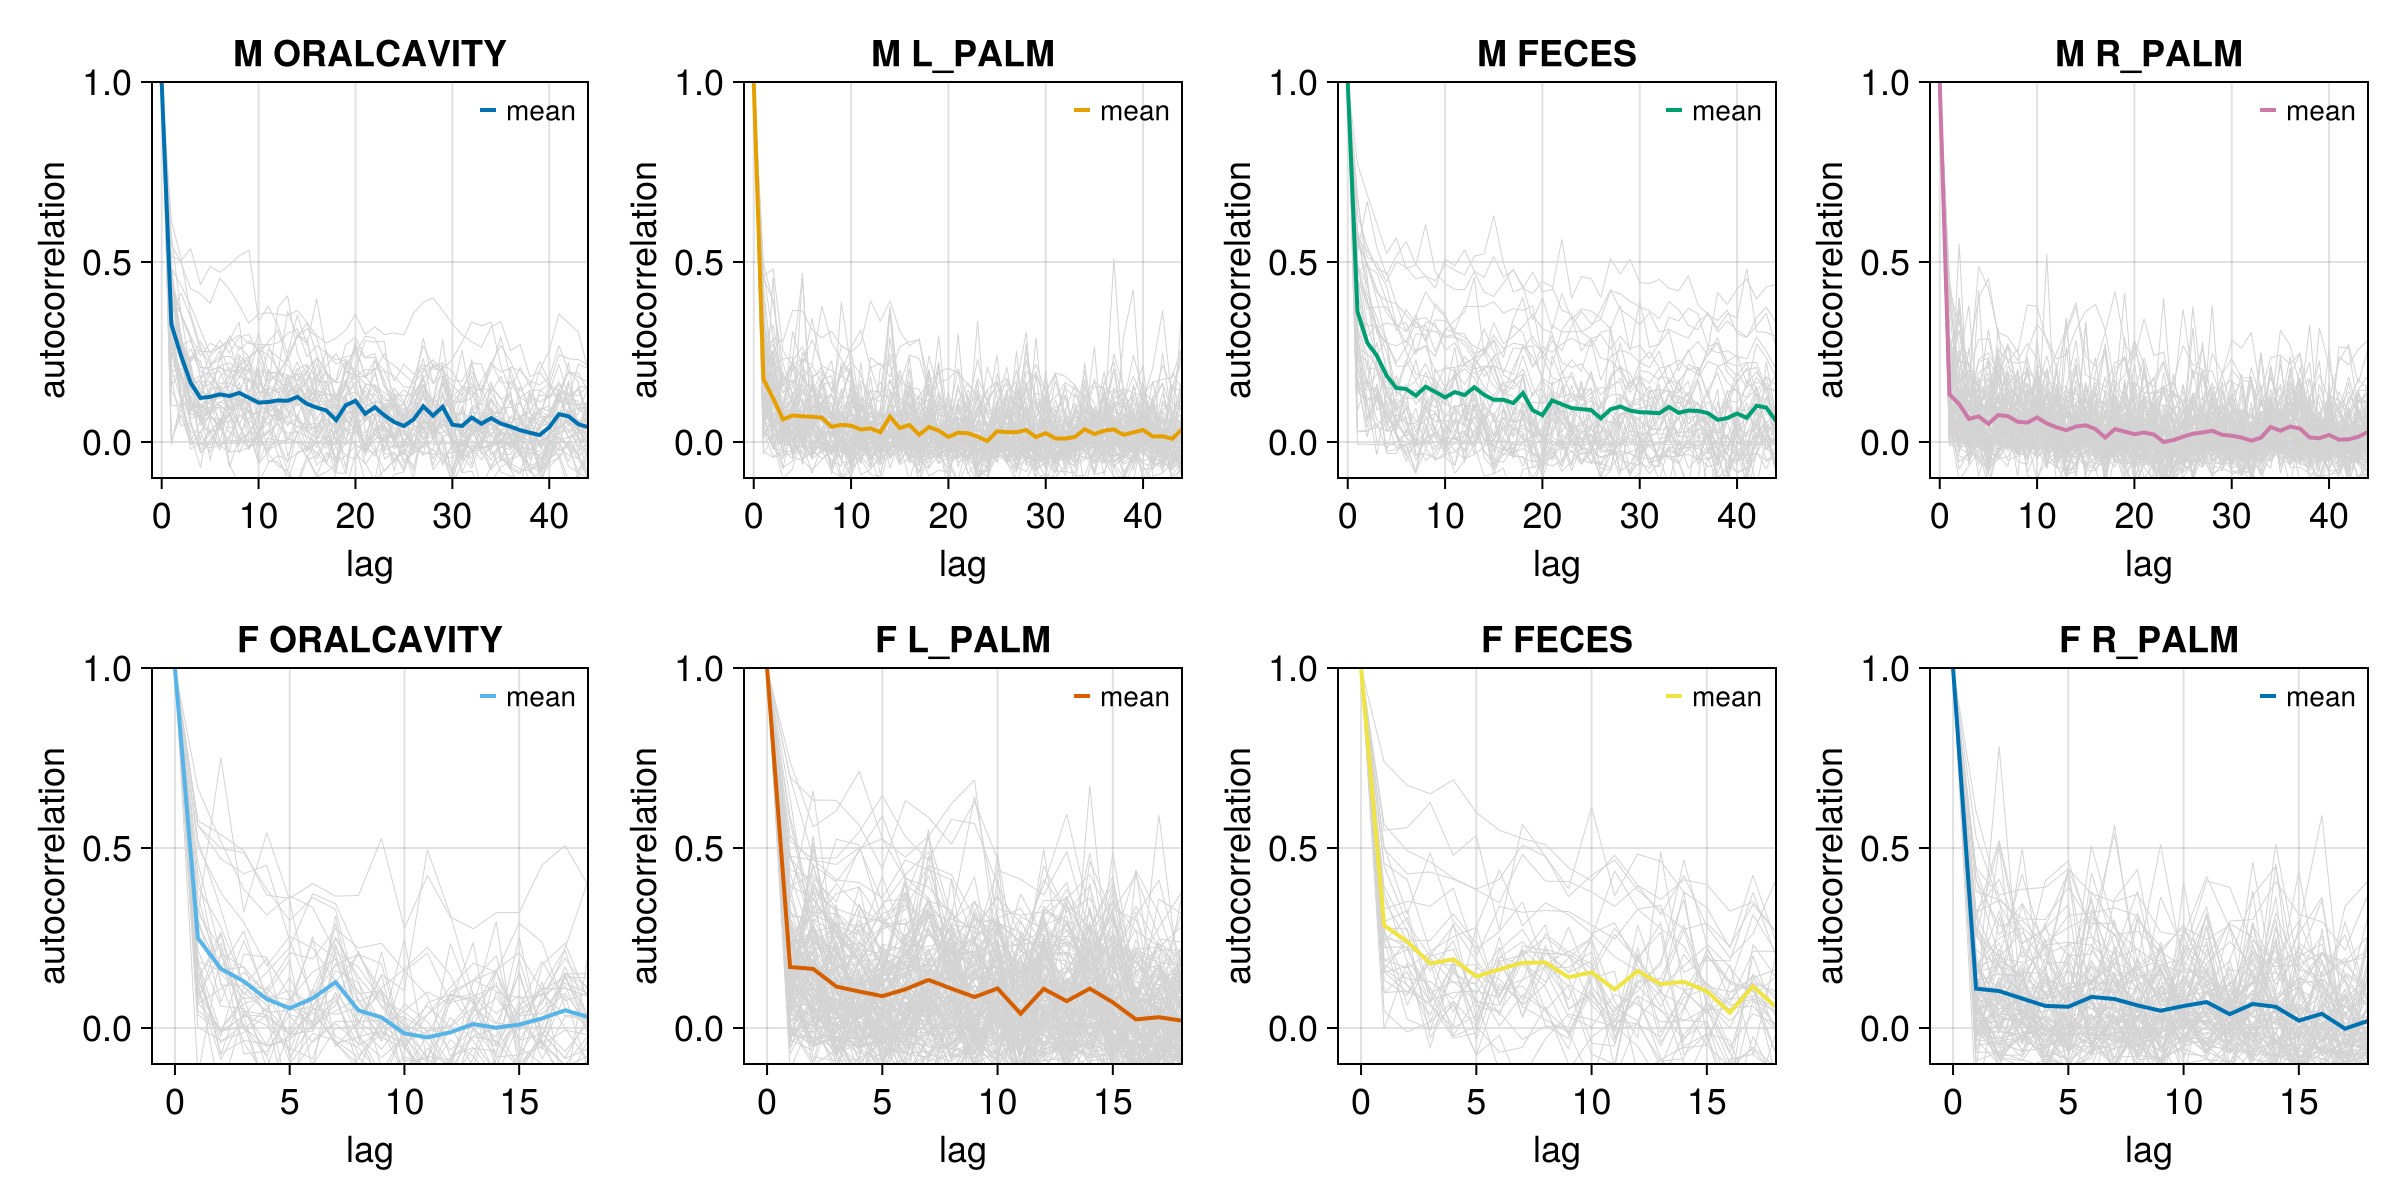

CairoMakie.Screen{IMAGE}


In [14]:
fig = Plots.combine_autocorr_plots(AutoCorrs, nrows=2, ncols=4, savepath=nothing)
display(fig)

### Power Spectrum

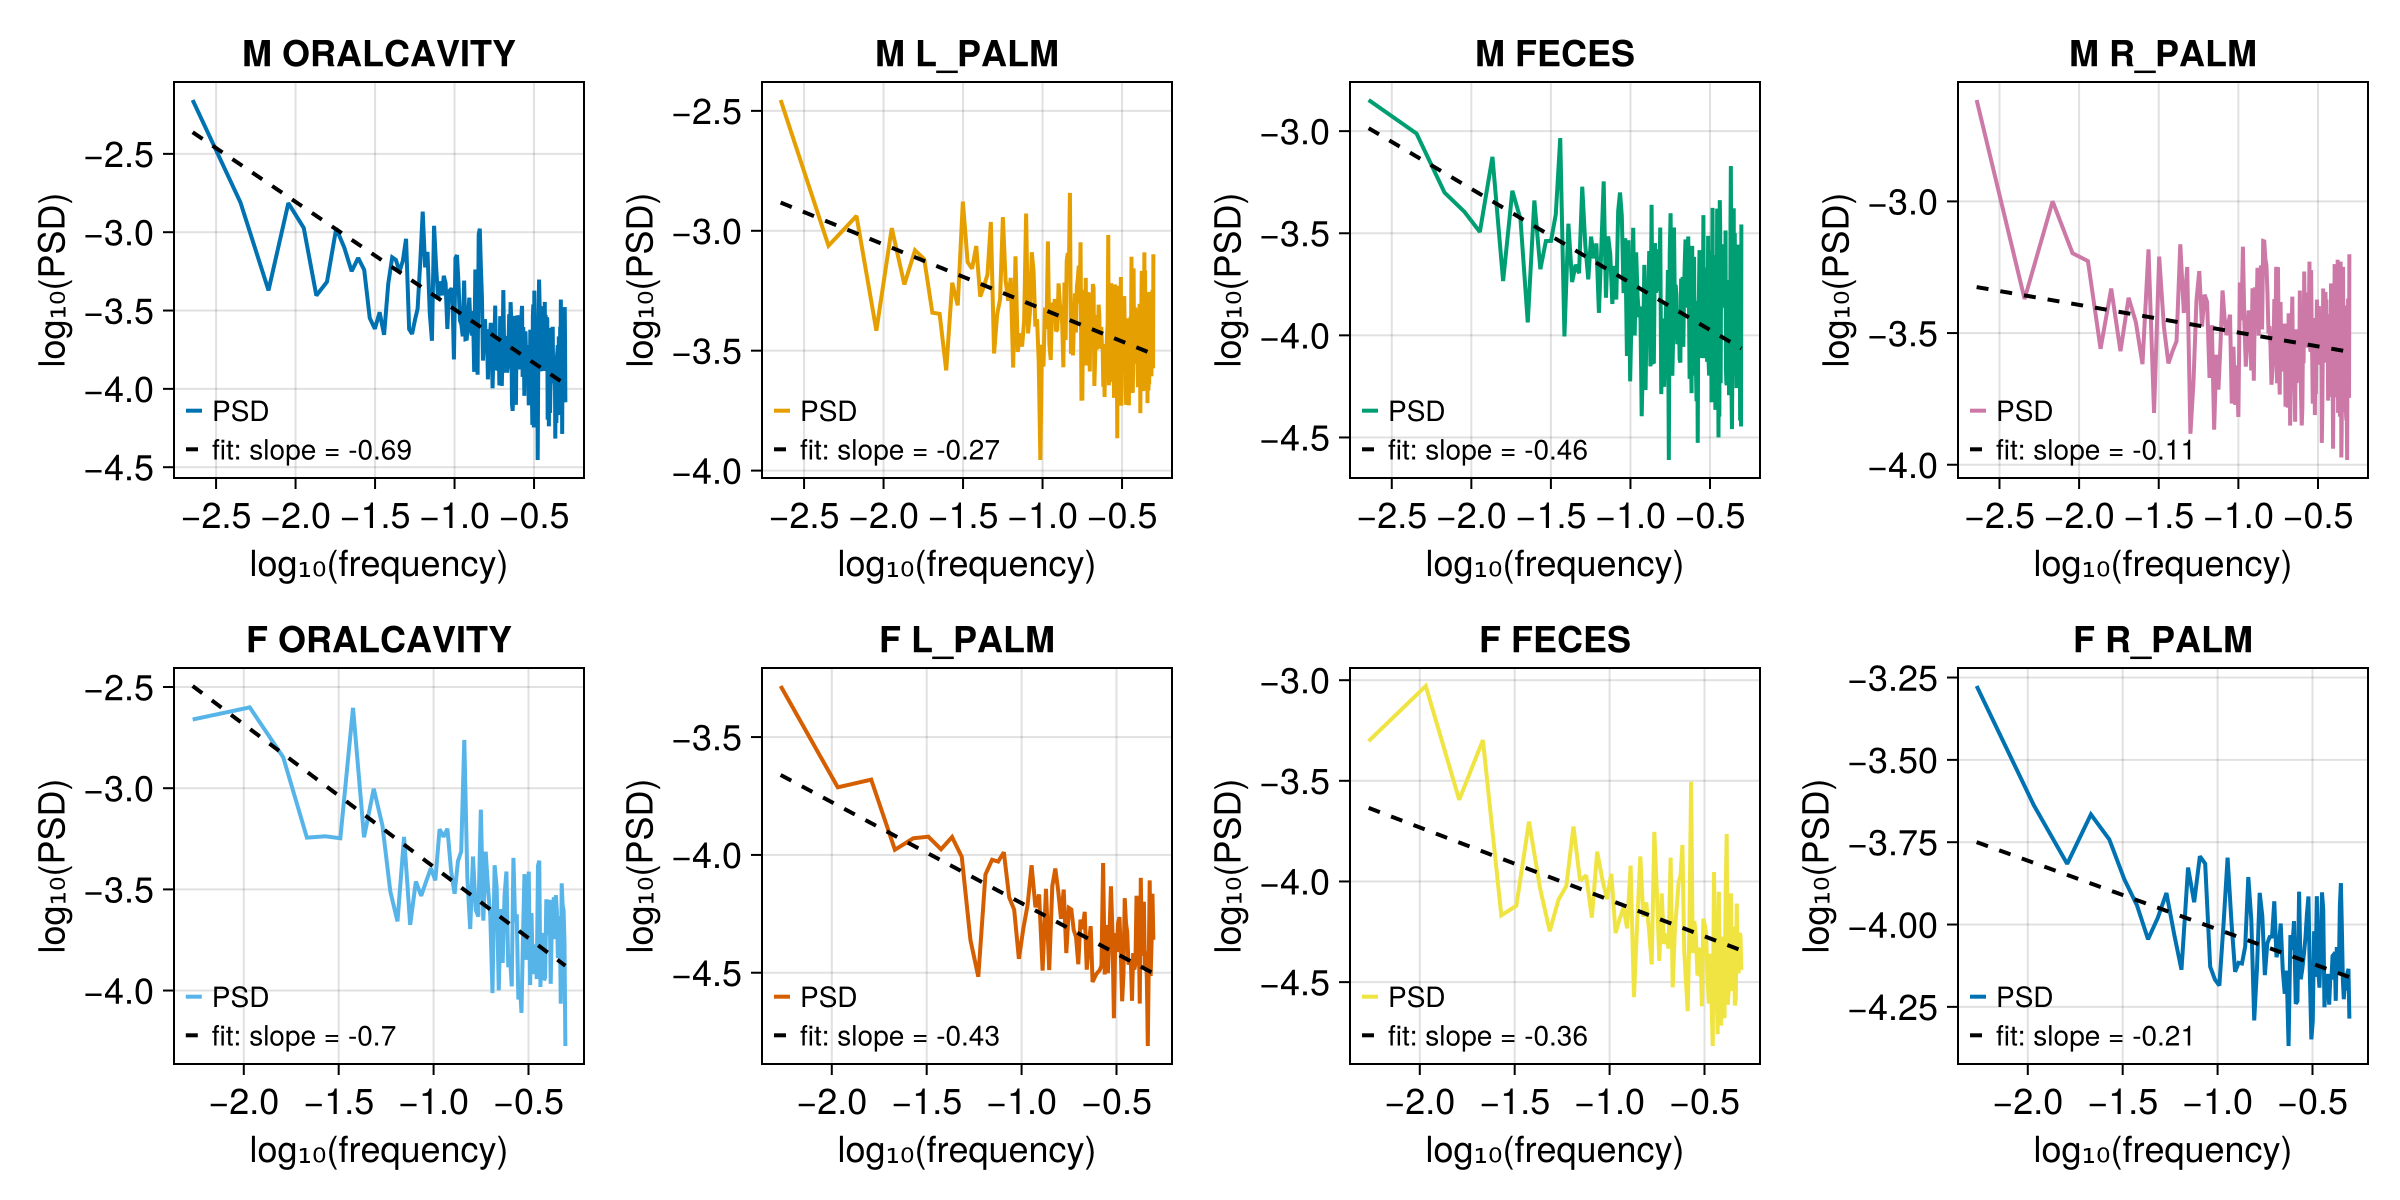

CairoMakie.Screen{IMAGE}


In [15]:
fig = Plots.combine_PSD_plots(PSDs, nrows=2, ncols=4, savepath=nothing)
display(fig)

### Cross Correlations

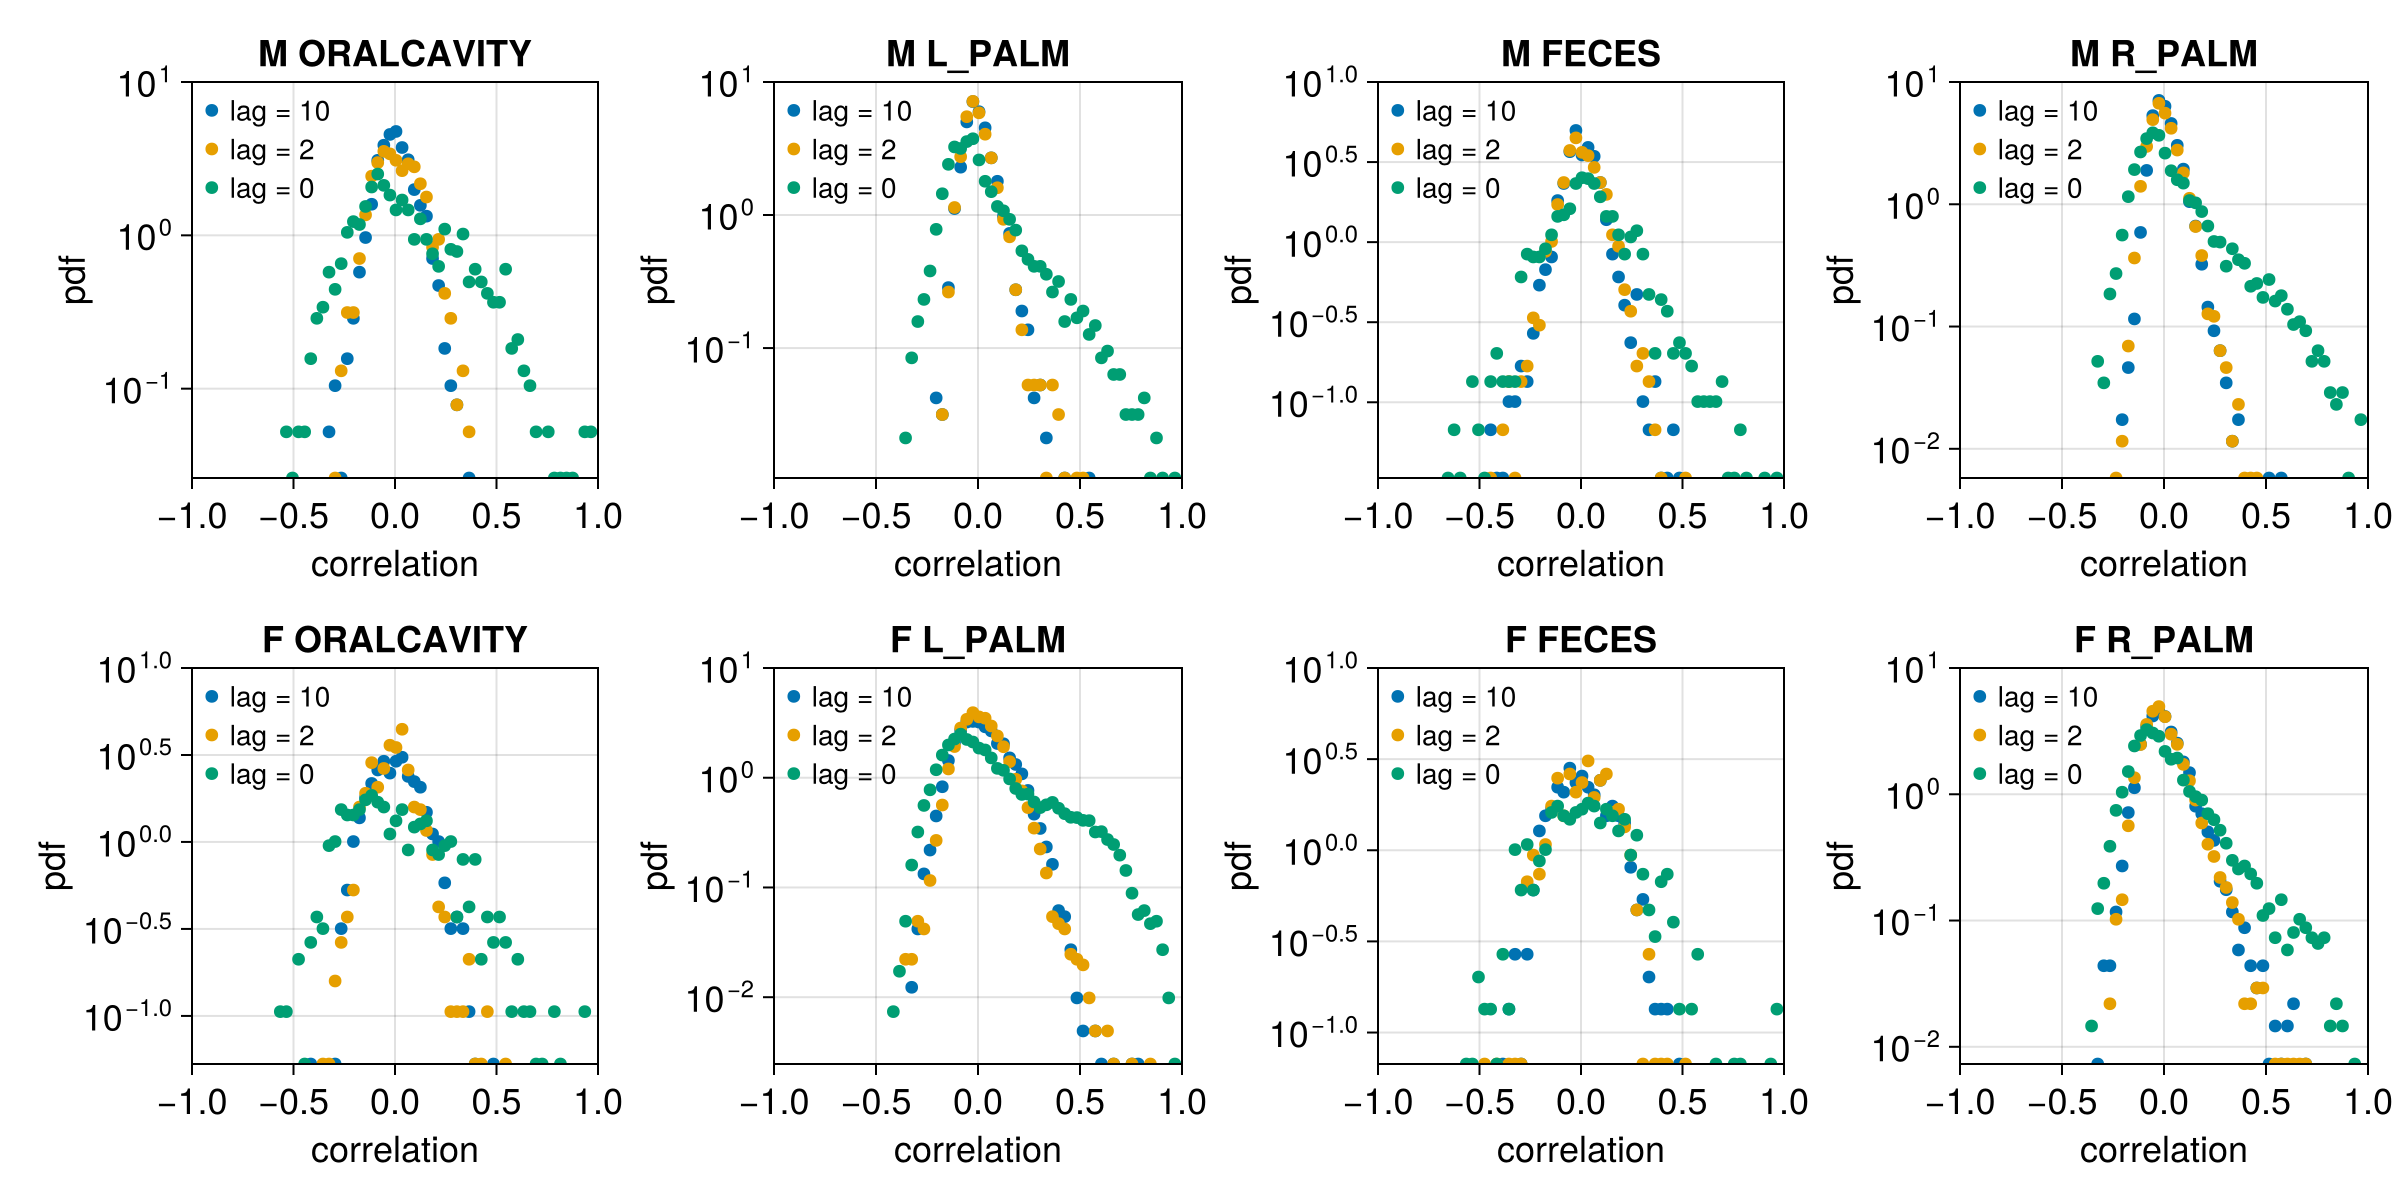

CairoMakie.Screen{IMAGE}


In [12]:
fig = Plots.combine_crossCorr_plots(CrossCorrs, nrows=2, ncols=4, Δb=0.03, savepath=nothing)
display(fig)